In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [37]:
BATCH_SIZE = 8
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10


In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_leaf_diseases",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 120 files belonging to 3 classes.


In [39]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [40]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 256, 256, 3)
[0 1 1 0 2 0 1 2]


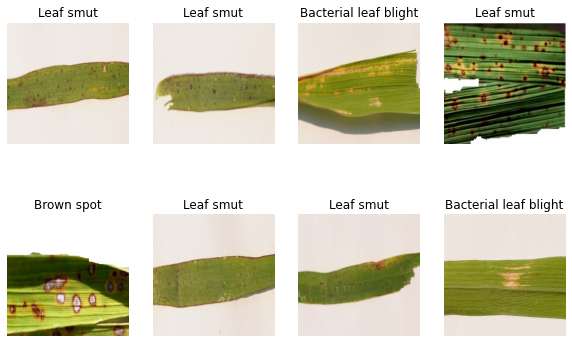

In [41]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [42]:
len(dataset)


15

In [43]:
train_size = 0.8
len(dataset)*train_size

12.0

In [44]:
train_ds = dataset.take(12)
len(train_ds)

12

In [45]:
test_ds = dataset.skip(12)
len(test_ds)

3

In [46]:
val_size=0.1
len(dataset)*val_size

1.5

In [47]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [48]:
test_ds = test_ds.skip(1)
len(test_ds)

2

In [49]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [50]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [51]:
len(train_ds)

12

In [52]:
len(val_ds)

1

In [53]:
len(test_ds)

2

In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [56]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [57]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (8, 256, 256, 3)          0         
                                                                 
 conv2d_6 (Conv2D)           (8, 254, 254, 32)         896       
                                                                 
 max_pooling2d_6 (MaxPooling  (8, 127, 127, 32)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (8, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (8, 62, 62, 64)          0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (8, 60, 60, 64)          

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
12/12 [==============================] - 10s 704ms/step - loss: 1.1168 - accuracy: 0.3333 - val_loss: 1.0983 - val_accuracy: 0.3750
Epoch 2/10
12/12 [==============================] - 8s 622ms/step - loss: 1.0998 - accuracy: 0.3438 - val_loss: 1.0948 - val_accuracy: 0.3750
Epoch 3/10
12/12 [==============================] - 7s 600ms/step - loss: 1.0971 - accuracy: 0.3333 - val_loss: 1.0906 - val_accuracy: 0.3750
Epoch 4/10
12/12 [==============================] - 7s 606ms/step - loss: 1.0957 - accuracy: 0.3646 - val_loss: 1.0814 - val_accuracy: 0.3750
Epoch 5/10
12/12 [==============================] - 7s 609ms/step - loss: 1.1062 - accuracy: 0.3750 - val_loss: 1.0895 - val_accuracy: 0.3750
Epoch 6/10
12/12 [==============================] - 7s 599ms/step - loss: 1.0932 - accuracy: 0.3542 - val_loss: 1.0859 - val_accuracy: 0.5000
Epoch 7/10
12/12 [==============================] - 8s 617ms/step - loss: 1.0658 - accuracy: 0.4062 - val_loss: 1.0493 - val_accuracy: 0.3750
Epoch

In [62]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 174ms/step - loss: 1.1710 - accuracy: 0.6250


In [63]:
scores

[1.170989751815796, 0.625]

In [64]:
history

In [65]:
history.params


{'verbose': 1, 'epochs': 10, 'steps': 12}

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [67]:
type(history.history['loss'])

list

In [68]:
len(history.history['loss'])

10

In [69]:
history.history['loss'][:5]


[1.1167510747909546,
 1.0997637510299683,
 1.0971001386642456,
 1.095712661743164,
 1.1062203645706177]

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

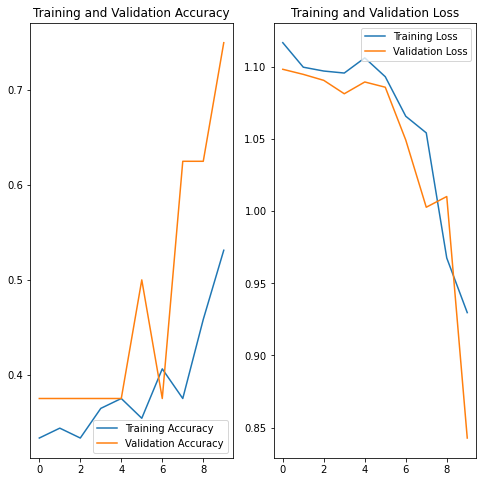

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Brown spot
1/1 [==============================] - 0s 424ms/step
predicted label: Brown spot


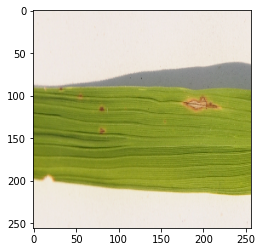

In [72]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


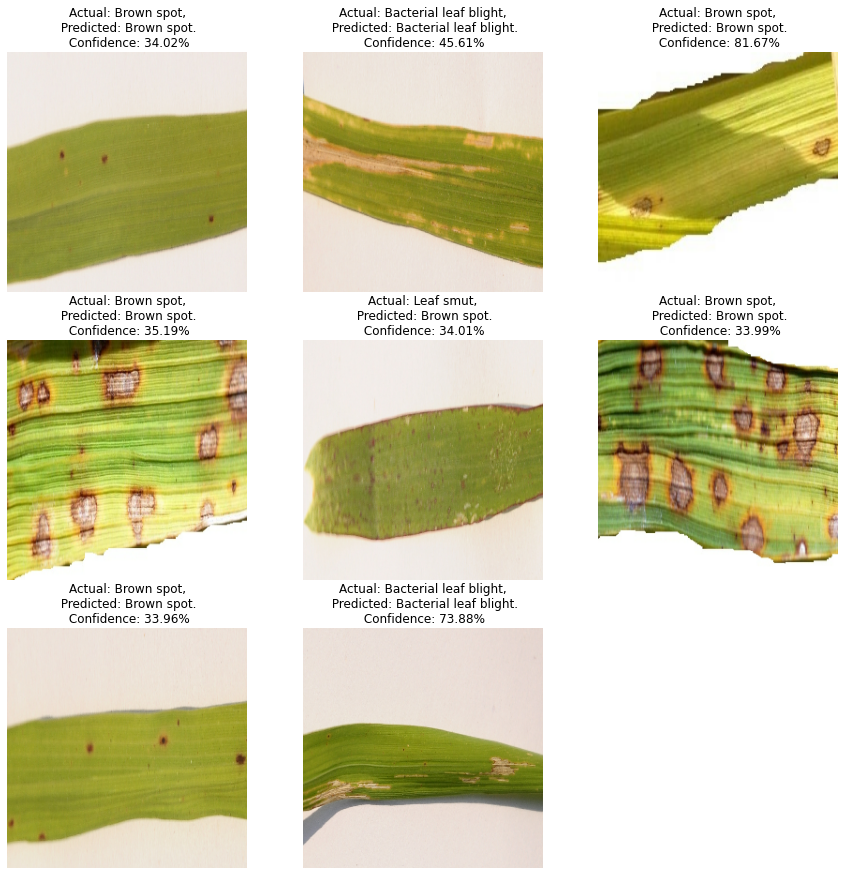

In [74]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [75]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/5\assets


INFO:tensorflow:Assets written to: ../models/5\assets


In [76]:
tf.keras.models.save_model(model,'my_model2.hdf5')

In [77]:
from PIL import Image,ImageOps

In [78]:
img = Image.open("DSC.jpg")
data = np.ndarray(shape=(1,256,256,3),dtype=np.float32)
size = (256,256)
image = ImageOps.fit(img,size,Image.ANTIALIAS)
image_array=np.asarray(image)
normalized_image_array = (image_array.astype(np.float32))
data[0]=normalized_image_array
prediction = model.predict(data)
print(prediction)
np.argmax(prediction)

1/1 [==============================] - 0s 59ms/step
[[0.31886637 0.3486942  0.33243942]]


C:\Users\Pranav\AppData\Local\Temp\ipykernel_12880\1464911829.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = ImageOps.fit(img,size,Image.ANTIALIAS)


1

import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)